In [1]:
# Ignorar advertencias generales
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers  


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

2024-12-12 09:29:32.164921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def set_seed(seed):
    # Fijar semilla para TensorFlow
    tf.random.set_seed(seed)
    # Fijar semilla para NumPy
    np.random.seed(seed)
    # Fijar semilla para random (nativo de Python)
    random.seed(seed)
    # Opcional: Asegurar reproducibilidad en operaciones paralelas de TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)  # Para reproducibilidad en hash
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Operaciones determinísticas en TensorFlow

set_seed(42)  # Establece una semilla fija

## Carga y Exploración de los Datos

In [3]:
# Cargar datos
X_train = pd.read_csv(r"../Datos/BinarioTrainBalanced.csv")
X_test = pd.read_csv(r"../Datos/BinarioTest1Balanced.csv")
X_test_knn = pd.read_csv(r"../Datos/BinarioTest2Balanced.csv")

In [4]:
def process_data(dataset, dataset_name):
    """
    Procesa un conjunto de datos separando características y etiquetas, 
    y calcula la distribución de clases.

    Parameters:
        dataset (pd.DataFrame): El conjunto de datos con características y etiquetas.
        dataset_name (str): Nombre del conjunto de datos (entrenamiento o prueba).

    Returns:
        X (np.ndarray): Características del conjunto de datos.
        Y (np.ndarray): Etiquetas del conjunto de datos.
    """
    print(f"\n\t\tDistribución de clases en {dataset_name}")
    nr_clases = dataset['CLASS_LABEL'].value_counts(sort=True)
    porcentajes = nr_clases * 100 / dataset.shape[0]
    distribucion = pd.DataFrame({'Cantidad': nr_clases, 'Porcentaje (%)': porcentajes})
    print(distribucion)

    # Separar características y etiquetas
    Y = dataset['CLASS_LABEL'].values
    X = dataset.drop(['CLASS_LABEL'], axis=1).values
    return X, Y


# Procesar conjuntos de datos
X_train, Y_train = process_data(X_train, "entrenamiento")
X_test, Y_test = process_data(X_test, "prueba AE")
X_test_knn, Y_test_knn = process_data(X_test_knn, "prueba Knn")

# Imprimir dimensiones de los conjuntos
print("\nDimensiones de los conjuntos:")
print(f"Entrenamiento: {X_train.shape}, {Y_train.shape}")
print(f"Prueba AE: {X_test.shape}, {Y_test.shape}")
print(f"Prueba Knn: {X_test_knn.shape}, {Y_test_knn.shape}")


		Distribución de clases en entrenamiento
             Cantidad  Porcentaje (%)
CLASS_LABEL                          
0                6212       50.064475
1                6196       49.935525

		Distribución de clases en prueba AE
             Cantidad  Porcentaje (%)
CLASS_LABEL                          
0                 777       50.096712
1                 774       49.903288

		Distribución de clases en prueba Knn
             Cantidad  Porcentaje (%)
CLASS_LABEL                          
1                 785       50.612508
0                 766       49.387492

Dimensiones de los conjuntos:
Entrenamiento: (12408, 606), (12408,)
Prueba AE: (1551, 606), (1551,)
Prueba Knn: (1551, 606), (1551,)


In [5]:
# Convertir los conjuntos de datos a tensores
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_tensor = tf.convert_to_tensor(Y_train, dtype=tf.int32)

X_test_tensor_ae = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_tensor_ae = tf.convert_to_tensor(Y_test, dtype=tf.int32)

X_test_tensor_knn = tf.convert_to_tensor(X_test_knn, dtype=tf.float32)
Y_test_tensor_knn = tf.convert_to_tensor(Y_test_knn, dtype=tf.int32)

# Imprimir los tamaños de los tensores
print("\nTamaños de los tensores:")
print(f"X_train_tensor: {X_train_tensor.shape}, Y_train_tensor: {Y_train_tensor.shape}")
print(f"X_test_tensor_ae: {X_test_tensor_ae.shape}, Y_test_tensor_ae: {Y_test_tensor_ae.shape}")
print(f"X_test_tensor_knn: {X_test_tensor_knn.shape}, Y_test_tensor_knn: {Y_test_tensor_knn.shape}")


Tamaños de los tensores:
X_train_tensor: (12408, 606), Y_train_tensor: (12408,)
X_test_tensor_ae: (1551, 606), Y_test_tensor_ae: (1551,)
X_test_tensor_knn: (1551, 606), Y_test_tensor_knn: (1551,)


## Entrenamos el modelo

In [6]:
# Crear un generador para obtener anclas, positivos y negativos
def generate_triplets(X, Y, batch_size):
    while True:
        indices = tf.random.shuffle(tf.range(len(Y)))
        X, Y = tf.gather(X, indices), tf.gather(Y, indices)
        for i in range(0, len(Y) - batch_size, batch_size):
            batch_indices = indices[i:i + batch_size]
            X_batch = tf.gather(X, batch_indices)
            Y_batch = tf.gather(Y, batch_indices)

            # Crear tripletas: ancla, positivo, negativo
            anchors, positives, negatives = [], [], []
            for j in range(batch_size):
                anchor = X_batch[j]
                label = Y_batch[j]

                positive_idx = tf.where(Y == label).numpy().flatten()
                positive_idx = positive_idx[positive_idx != j]  # Excluir ancla
                negative_idx = tf.where(Y != label).numpy().flatten()

                if len(positive_idx) > 0 and len(negative_idx) > 0:
                    positive = X[tf.random.shuffle(positive_idx)[0]]
                    negative = X[tf.random.shuffle(negative_idx)[0]]
                    anchors.append(anchor)
                    positives.append(positive)
                    negatives.append(negative)

            yield tf.stack(anchors), tf.stack(positives), tf.stack(negatives)

In [7]:
# Definir la pérdida de tripleta personalizada
def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)

In [8]:
# Configuración de hiperparámetros
embedding_dim = 20  # Dimensión de los embeddings
batch_size = 32
margin = 1.0

# Definir el modelo de embeddings
embedding_model = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(300, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(embedding_dim, activation=None),  # Salida de embeddings
])


In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Inicializar listas para recolectar la pérdida
training_loss = []

# Entrenamiento del modelo
triplet_generator = generate_triplets(X_train, Y_train, batch_size)
steps_per_epoch = len(Y_train) // batch_size


for epoch in range(10):  # Número de épocas
    print(f"Epoch {epoch+1}")
    epoch_loss = 0
    for step in range(steps_per_epoch):  # Iterar un número fijo de pasos
        anchors, positives, negatives = next(triplet_generator)  # Obtener tripletas
        with tf.GradientTape() as tape:
            anchor_embeddings = embedding_model(anchors)
            positive_embeddings = embedding_model(positives)
            negative_embeddings = embedding_model(negatives)

            # Calcular la pérdida de tripleta
            loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings, margin)

        # Actualizar pesos del modelo
        gradients = tape.gradient(loss, embedding_model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, embedding_model.trainable_weights))

        epoch_loss += loss.numpy()
        if step % 100 == 0:  # Mostrar progreso
            print(f"Step {step}, Loss: {loss.numpy()}")

    avg_epoch_loss = epoch_loss / steps_per_epoch
    training_loss.append(avg_epoch_loss)  # Guardar la pérdida promedio por época
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_epoch_loss}")


Epoch 1
Step 0, Loss: 0.9738582372665405
Step 100, Loss: 0.5712666511535645
Step 200, Loss: 0.5346813201904297
Step 300, Loss: 0.5590841770172119
Epoch 1 completed. Avg Loss: 0.639357651465931
Epoch 2
Step 0, Loss: 0.39405208826065063
Step 100, Loss: 0.6992254257202148
Step 200, Loss: 0.7452223300933838
Step 300, Loss: 0.7798466086387634
Epoch 2 completed. Avg Loss: 0.6011051453207198
Epoch 3
Step 0, Loss: 0.7059799432754517
Step 100, Loss: 0.7060180902481079
Step 200, Loss: 0.7266831398010254
Step 300, Loss: 0.613310694694519
Epoch 3 completed. Avg Loss: 0.571047627802659
Epoch 4
Step 0, Loss: 0.5891561508178711
Step 100, Loss: 0.6890636682510376
Step 200, Loss: 0.4460570216178894
Step 300, Loss: 0.6122862100601196
Epoch 4 completed. Avg Loss: 0.5612661844307139
Epoch 5
Step 0, Loss: 0.5397670269012451
Step 100, Loss: 0.40674281120300293
Step 200, Loss: 0.5834778547286987
Step 300, Loss: 0.798972487449646
Epoch 5 completed. Avg Loss: 0.5579121830543499
Epoch 6
Step 0, Loss: 0.52319085

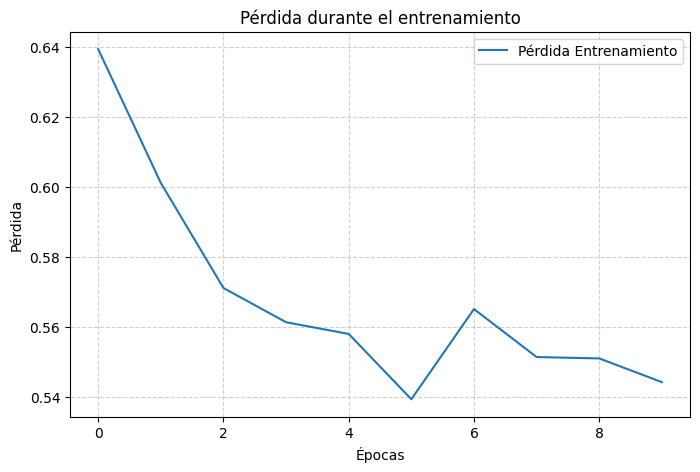

In [10]:
# Graficar la pérdida
def plot_training_loss(training_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(training_loss, label='Pérdida Entrenamiento')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Llamar a la función para graficar
plot_training_loss(training_loss)

In [11]:
# Generar y medir el tiempo de generación de embeddings
start_time = time.time()
train_embeddings = embedding_model.predict(X_train_tensor, batch_size=32, verbose=1)
test_ae_embeddings = embedding_model.predict(X_test_tensor_ae, batch_size=32, verbose=1)
test_knn_embeddings = embedding_model.predict(X_test_tensor_knn, batch_size=32, verbose=1)
end_time = time.time()

# Verificar las dimensiones del espacio latente
print("\nGeneración de embeddings completada.")
print(f"- Tiempo total de generación: {end_time - start_time:.2f} segundos")
print(f"- Dimensiones de los datos de entrenamiento (X_train): {X_train_tensor.shape}")
print(f"- Dimensiones del espacio latente (embeddings de entrenamiento): {train_embeddings.shape}")
print(f"- Dimensiones del espacio latente (embeddings de prueba): {test_ae_embeddings.shape}")

# Mostrar ejemplo de embeddings
print("\nEjemplo de embeddings de entrenamiento:")
print(train_embeddings[:3])  # Muestra los primeros 5 embeddings


49/49 [==============================] - 0s 2ms/step

Generación de embeddings completada.
- Tiempo total de generación: 1.84 segundos
- Dimensiones de los datos de entrenamiento (X_train): (12408, 606)
- Dimensiones del espacio latente (embeddings de entrenamiento): (12408, 20)
- Dimensiones del espacio latente (embeddings de prueba): (1551, 20)

Ejemplo de embeddings de entrenamiento:
[[-0.9992319  -0.03091305 -0.752236   -0.43988606  1.2188351  -0.19263153
  -0.27980104  0.1528924   0.1584087   0.35285103  0.07475118  0.56618327
  -0.33897233 -0.11900897  0.39430317 -0.02996365 -1.3650951  -1.6101846
   0.08176383  0.2871884 ]
 [-0.698103    0.05872099 -0.2835033   0.03262272  0.7490006  -0.09980707
  -0.1121951   0.1659039  -0.07812394  0.25245553  0.11559805  0.67020935
  -0.13706948 -0.11510416  0.06294928 -0.11902425 -0.82415134 -1.0249784
   0.08887126  0.26693326]
 [-0.7202555   0.05898976 -0.3172596  -0.00336417  0.7988502  -0.10773079
  -0.11878254  0.1726314  -0.05730959  0

In [12]:

# Reducir el espacio latente a 2 dimensiones usando t-SNE con medición de tiempo
tsne = TSNE(
    n_components=2,  # Reducir a 2 dimensiones
    random_state=42,  # Semilla para reproducibilidad
    perplexity=30,    # Ajustar según el tamaño del dataset (valor típico entre 5 y 50)
    n_iter=1000,      # Aumentar el número de iteraciones para una mejor convergencia
    learning_rate=200,  # Valor típico: entre 10 y 1000
    init='pca'        # Inicialización con PCA para estabilidad
)

# Medir tiempo de ejecución
start_time = time.time()
espacio_latente_2D = tsne.fit_transform(train_embeddings)
end_time = time.time()

# Imprimir tiempo total
print(f"Tiempo de ejecución de t-SNE: {end_time - start_time:.2f} segundos")

Tiempo de ejecución de t-SNE: 22.52 segundos


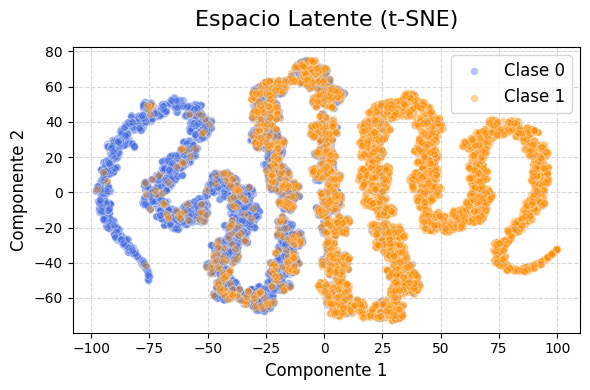

In [13]:
# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(6, 4))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.4,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()


Ajustando el modelo KNN

Realizando predicciones en el conjunto de prueba...

--- Evaluación del Desempeño ---

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.8339    0.9243    0.8768       766
           1     0.9174    0.8204    0.8662       785

    accuracy                         0.8717      1551
   macro avg     0.8757    0.8723    0.8715      1551
weighted avg     0.8762    0.8717    0.8714      1551


Matriz de Confusión:
[[708  58]
 [141 644]]


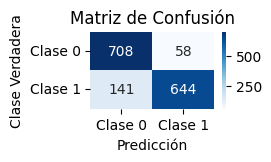

In [15]:
# Ajustar KNN con embeddings de entrenamiento
print("\nAjustando el modelo KNN")
knn = KNeighborsClassifier(n_neighbors=20, metric='euclidean', n_jobs=-1)
knn.fit(test_ae_embeddings, Y_test)


# Predicciones en conjunto de prueba
print("\nRealizando predicciones en el conjunto de prueba...")
Y_pred = knn.predict(test_knn_embeddings)

# Evaluación de desempeño
print("\n--- Evaluación del Desempeño ---")
print("\nReporte de Clasificación:")
print(classification_report(Y_test_knn, Y_pred, digits=4))  

print("\nMatriz de Confusión:")
conf_matrix = confusion_matrix(Y_test_knn, Y_pred)
print(conf_matrix)

# Visualización de la matriz de confusión (opcional)
plt.figure(figsize=(2, 1))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Clase Verdadera")
plt.show()
